<a href="https://colab.research.google.com/github/wassimdiallo67-alt/G-n-ration-de-texte/blob/main/text_generation_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Génération de Texte avec LSTM


In [29]:

# CONFIGURATION
LONGUEUR_SEQUENCE = 20
TAILLE_BATCH = 256
NB_EPOQUES =40
DIM_EMBEDDING = 128
TAILLE_CACHEE = 256
TAUX_APPRENTISSAGE = 0.0005
TAUX_DROPOUT = 0.5
TAILLE_VOCAB = 8000
MAX_TOKENS = 80000

In [30]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import re
import pickle

print("CONFIGURATION ANTI-OVERFITTING")
print(f"LONGUEUR_SEQUENCE  = {LONGUEUR_SEQUENCE}")
print(f"TAILLE_BATCH       = {TAILLE_BATCH}")
print(f"DIM_EMBEDDING      = {DIM_EMBEDDING}")
print(f"TAILLE_CACHEE      = {TAILLE_CACHEE}")
print(f"TAUX_DROPOUT       = {TAUX_DROPOUT}")
print(f"TAUX_APPRENTISSAGE = {TAUX_APPRENTISSAGE}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

CONFIGURATION ANTI-OVERFITTING
LONGUEUR_SEQUENCE  = 20
TAILLE_BATCH       = 256
DIM_EMBEDDING      = 128
TAILLE_CACHEE      = 256
TAUX_DROPOUT       = 0.5
TAUX_APPRENTISSAGE = 0.0005
Device: cpu


## 1. Données

In [31]:
df = pd.read_csv('dataset.csv')
texte = ' '.join(df['text'].astype(str).tolist())
texte = re.sub(r'[^a-zA-ZàâäéèêëïîôùûüçÀÂÄÉÈÊËÏÎÔÙÛÜÇ\s]', ' ', texte)
texte = re.sub(r'\s+', ' ', texte).lower().strip()
mots = texte.split()[:MAX_TOKENS]
print(f"Mots: {len(mots):,}")

Mots: 80,000


## 2. Vocabulaire

In [32]:
from collections import Counter
freq = Counter(mots)
mots_communs = freq.most_common(TAILLE_VOCAB - 1)

mot_vers_idx = {'<PAD>': 0}
for i, (mot, _) in enumerate(mots_communs):
    mot_vers_idx[mot] = i + 1
idx_vers_mot = {i: m for m, i in mot_vers_idx.items()}

print(f"Vocabulaire: {len(mot_vers_idx)} mots")

Vocabulaire: 8000 mots


## 3. Séquences

In [33]:
encoded = [mot_vers_idx.get(m, 0) for m in mots]

X, y = [], []
for i in range(LONGUEUR_SEQUENCE, len(encoded)):
    X.append(encoded[i-LONGUEUR_SEQUENCE:i])
    y.append(encoded[i])

X = torch.LongTensor(X)
y = torch.LongTensor(y)

# Split 80/20 (plus de validation)
n = int(len(X) * 0.8)
X_train, X_val = X[:n], X[n:]
y_train, y_val = y[:n], y[n:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=TAILLE_BATCH, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=TAILLE_BATCH)

print(f"Train: {len(X_train):,}, Val: {len(X_val):,}")

Train: 63,984, Val: 15,996


## 4. Modèle avec régularisation

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.drop1 = nn.Dropout(dropout)

        # Une seule couche LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        self.drop2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.drop1(self.embedding(x))
        out, _ = self.lstm(emb)
        out = self.drop2(out[:, -1, :])
        return self.fc(out)

model = LSTMModel(len(mot_vers_idx), DIM_EMBEDDING, TAILLE_CACHEE, TAUX_DROPOUT).to(device)
print(f"Paramètres: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=TAUX_APPRENTISSAGE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

Paramètres: 3,475,264


## 5. Entraînement

In [35]:
history = {'train': [], 'val': []}
best_loss = float('inf')
patience = 0

for epoch in range(NB_EPOQUES):
    # Train
    model.train()
    train_loss = 0
    for bx, by in train_loader:
        bx, by = bx.to(device), by.to(device)
        optimizer.zero_grad()
        out = model(bx)
        loss = criterion(out, by)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            val_loss += criterion(model(bx), by).item()
    val_loss /= len(val_loader)

    scheduler.step(val_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    marker = ""
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'model.pth')
        patience = 0
        marker = " *"
    else:
        patience += 1

    print(f"Époque {epoch+1:2d}/{NB_EPOQUES} - Train: {train_loss:.3f} - Val: {val_loss:.3f}")

    # Early stopping
    if patience >= 7:
        print("Early stopping!")
        break

model.load_state_dict(torch.load('model.pth'))
print(f"\nMeilleur modèle (val: {best_loss:.3f})")

Époque  1/40 - Train: 7.033 - Val: 6.724
Époque  2/40 - Train: 6.430 - Val: 6.580
Époque  3/40 - Train: 6.243 - Val: 6.427
Époque  4/40 - Train: 6.064 - Val: 6.277
Époque  5/40 - Train: 5.901 - Val: 6.162
Époque  6/40 - Train: 5.770 - Val: 6.087
Époque  7/40 - Train: 5.652 - Val: 6.007
Époque  8/40 - Train: 5.554 - Val: 5.967
Époque  9/40 - Train: 5.459 - Val: 5.929
Époque 10/40 - Train: 5.381 - Val: 5.904
Époque 11/40 - Train: 5.306 - Val: 5.871
Époque 12/40 - Train: 5.234 - Val: 5.860
Époque 13/40 - Train: 5.171 - Val: 5.834
Époque 14/40 - Train: 5.113 - Val: 5.823
Époque 15/40 - Train: 5.053 - Val: 5.807
Époque 16/40 - Train: 4.995 - Val: 5.807
Époque 17/40 - Train: 4.946 - Val: 5.797
Époque 18/40 - Train: 4.889 - Val: 5.784
Époque 19/40 - Train: 4.845 - Val: 5.786
Époque 20/40 - Train: 4.796 - Val: 5.782
Époque 21/40 - Train: 4.750 - Val: 5.775
Époque 22/40 - Train: 4.709 - Val: 5.768
Époque 23/40 - Train: 4.662 - Val: 5.778
Époque 24/40 - Train: 4.622 - Val: 5.767
Époque 25/40 - T

## 6. Courbes

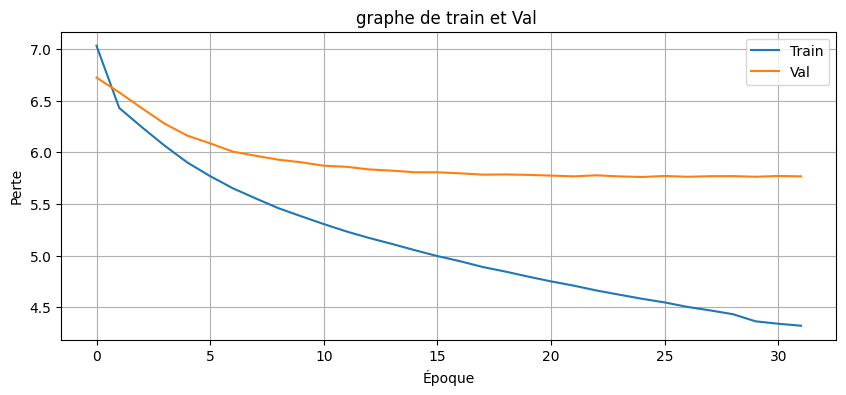

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history['train'], label='Train')
plt.plot(history['val'], label='Val')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)
plt.title('graphe de train et Val ')
plt.savefig('courbes.png')
plt.show()

## 7. Génération

In [37]:
def generate(seed, length=50, temp=0.8):
    model.eval()
    words = seed.lower().split()

    for _ in range(length):
        seq = [mot_vers_idx.get(w, 0) for w in words[-LONGUEUR_SEQUENCE:]]
        while len(seq) < LONGUEUR_SEQUENCE:
            seq.insert(0, 0)

        x = torch.LongTensor([seq]).to(device)
        with torch.no_grad():
            logits = model(x)[0]
            logits[0] = -1e9  # Pas de <PAD>
            probs = torch.softmax(logits / temp, dim=0)

            # Top-k
            top_p, top_i = torch.topk(probs, 30)
            top_p = top_p / top_p.sum()
            idx = top_i[torch.multinomial(top_p, 1)].item()

        word = idx_vers_mot.get(idx, '')
        if word and len(words) < 2 or words[-1] != word:
            words.append(word)

    return ' '.join(words)

for seed in ["le comte de monte cristo", "edmond dantes", "un jour"]:
    print(f"\n[{seed}]")
    print(generate(seed))


[le comte de monte cristo]
le comte de monte cristo le pharaon etait un mot et pour une seconde heure l inspecteur mais qui avait ete conduit de l abbe qui lui etait demeure et la moitie de son fils et en voyant s arretant et se laissa comme un soupir et s ouvrit de son lit que lui avait

[edmond dantes]
edmond dantes regarda les yeux noirs comme la porte il n est pas a dire de moi de la famille et la douane que je ne m ai pas mieux je ne veux pas de l ile d elbe au lieu de dantes et qui se passe a la main de la

[un jour]
un jour que la porte de villefort n eut t en aide il y a pas la liberte d une facon de l inspecteur en verite mais il etait arrive sur son cachot de villefort et s en ouvrant un autre s ecria t il en faisant un regard et de son


## 8. Sauvegarde

In [38]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump({'mot_vers_idx': mot_vers_idx, 'idx_vers_mot': idx_vers_mot}, f)
print("OK")

OK
